# Homing vector coding

We want to test whether neurons encode the direction of the home base relative to their heading direction. 

To test this we calculate the angle between two vectors: 

1) Head direction 
2) A vector originating on the animal head and pointing in the direction of the home base.

<img src="figures/homing_angle.png" width=400>

What we need is:
* head-direction of the animal
* the position of the animal
* the position of the home base



In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def egocentric_direction_to_reference_point(x_animal, y_animal, hd, x_ref,y_ref):
    """
    Function to calculate the egocentric direction of a reference point relative the the head direction of the animal.
    
    Angle between 2 vectors:
    1) A vector from the animal head pointing in it head direction 
    2) A vector from the animals head pointing towards a reference point
    
    This tells you in which direction the reference point was relative to the antero-posterior axis of the animal head.
    
    np.arctan2 is used to get the angle of the vector from animal position to ref point
    We use a second np.arctan2 to make sure the results are within -pi to pi
    The values are reversed so that -pi/2 is to the left and pi/2 is to right
    
    
    Arguments:
    x_animal: 1D np.array of with x position of the animal
    y_animal: 1D np.array of the y position of the animal
    hd: 1D np.array of the head direction of the animal
    x_ref: reference point x coordinate
    y_ref: reference point y coordinate
    
    Returns:
    Egocentric angle in radian of the reference point relative to a vector pointing in front of the animal's head. 
        0: in front of the animal, -pi: to the left, pi: to the right, 2*pi : to the back
    """
    
    
    return - np.arctan2(np.sin(np.arctan2(y_ref-y_animal,x_ref-x_animal)-hd),np.cos(np.arctan2(y_ref-y_animal,x_ref-x_animal)-hd))

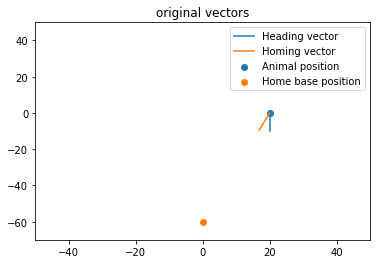

Egocentric homing angle: 0.32175055439664235


In [50]:
hd=-np.pi/2 # head direction
hdUnitVector= np.array([np.cos(hd),np.sin(hd)])
animalPosition = np.array([20,0])
homeBasePosition = np.array([0,-60])
homeBaseVector= homeBasePosition - animalPosition # vector from animal to home base
homeBaseUnitVector =  homeBaseVector/np.sqrt(homeBaseVector@homeBaseVector)


plt.title("original vectors")
plt.scatter(animalPosition[0],animalPosition[1],label="Animal position")
plt.scatter(homeBasePosition[0],homeBasePosition[1], label="Home base position") 
plt.plot([animalPosition[0],animalPosition[0]+hdUnitVector[0]*10],[animalPosition[1],animalPosition[1]+hdUnitVector[1]*10],label="Heading vector") # hd
plt.plot([animalPosition[0],animalPosition[0]+homeBaseUnitVector[0]*10],[animalPosition[1],animalPosition[1]+homeBaseUnitVector[1]*10],label="Homing vector") 
plt.xlim(-50,50)
plt.ylim(-70,50)
plt.legend()
plt.show()

print("Egocentric homing angle:",egocentric_direction_to_reference_point(animalPosition[0],animalPosition[1], hd, homeBasePosition[0],homeBasePosition[1]))


## Repeat the HD analysis, with the exception that we replace HD by egocentic homing angle (EHA) in the ap.pose

The code should be the same as in open_field_list_dark_hd_histo.ipynb

In [51]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 44 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 44/44 [00:29<00:00,  1.49it/s]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [52]:
def getEhaHisto(ses,sSes,interName="circ80",onlyArena=False):
    """
    Get all the egocentric homing angle histo of the data within the intervals of interest
    """
    x_ref = 0
    y_ref = -45
        
    sSes.ap.load_pose_from_file() # get original hd data
    
    # calculate EHA
    eha = egocentric_direction_to_reference_point(sSes.ap.pose[:,1],
                                                  sSes.ap.pose[:,2],
                                                  sSes.ap.pose[:,4],
                                                  x_ref,y_ref)
    
    # replace HD by EHA in ap.pose_ori[:4]
    sSes.ap.pose_ori[:,4] = eha
    
    
    # ap.set_intervals takes the HD data from ap.pose_ori
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    
    if onlyArena:
        # this should come after setting the time intervals, will be reset when calling sSes.ap.set_intervals again
        sSes.ap.invalid_outside_spatial_area(shape="circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10, smoothing=True)
        
    histoList = [ n.spatial_properties.firing_rate_head_direction_histo for n in sSes.cg.neuron_list ]
    histoStack = np.stack(histoList, axis=0)
    
    # put back HD data into the sSes.ap.pose to avoid confusion
    sSes.ap.load_pose_from_file() # get original hd data
    
    return histoStack


In [53]:
#[ (i,ses.name) for i,ses in enumerate(sSesList)]
sSes = sSesList[41]
ses = myProject.sessionList[41]
res = getEhaHisto(ses,sSes,interName="dark",onlyArena=True)

/tmp/ipykernel_48253/3789952760.py:9: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax[r,c].set_ylim(0,np.nanmax(res[i]))
/tmp/ipykernel_48253/3789952760.py:9: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax[r,c].set_ylim(0,np.nanmax(res[i]))


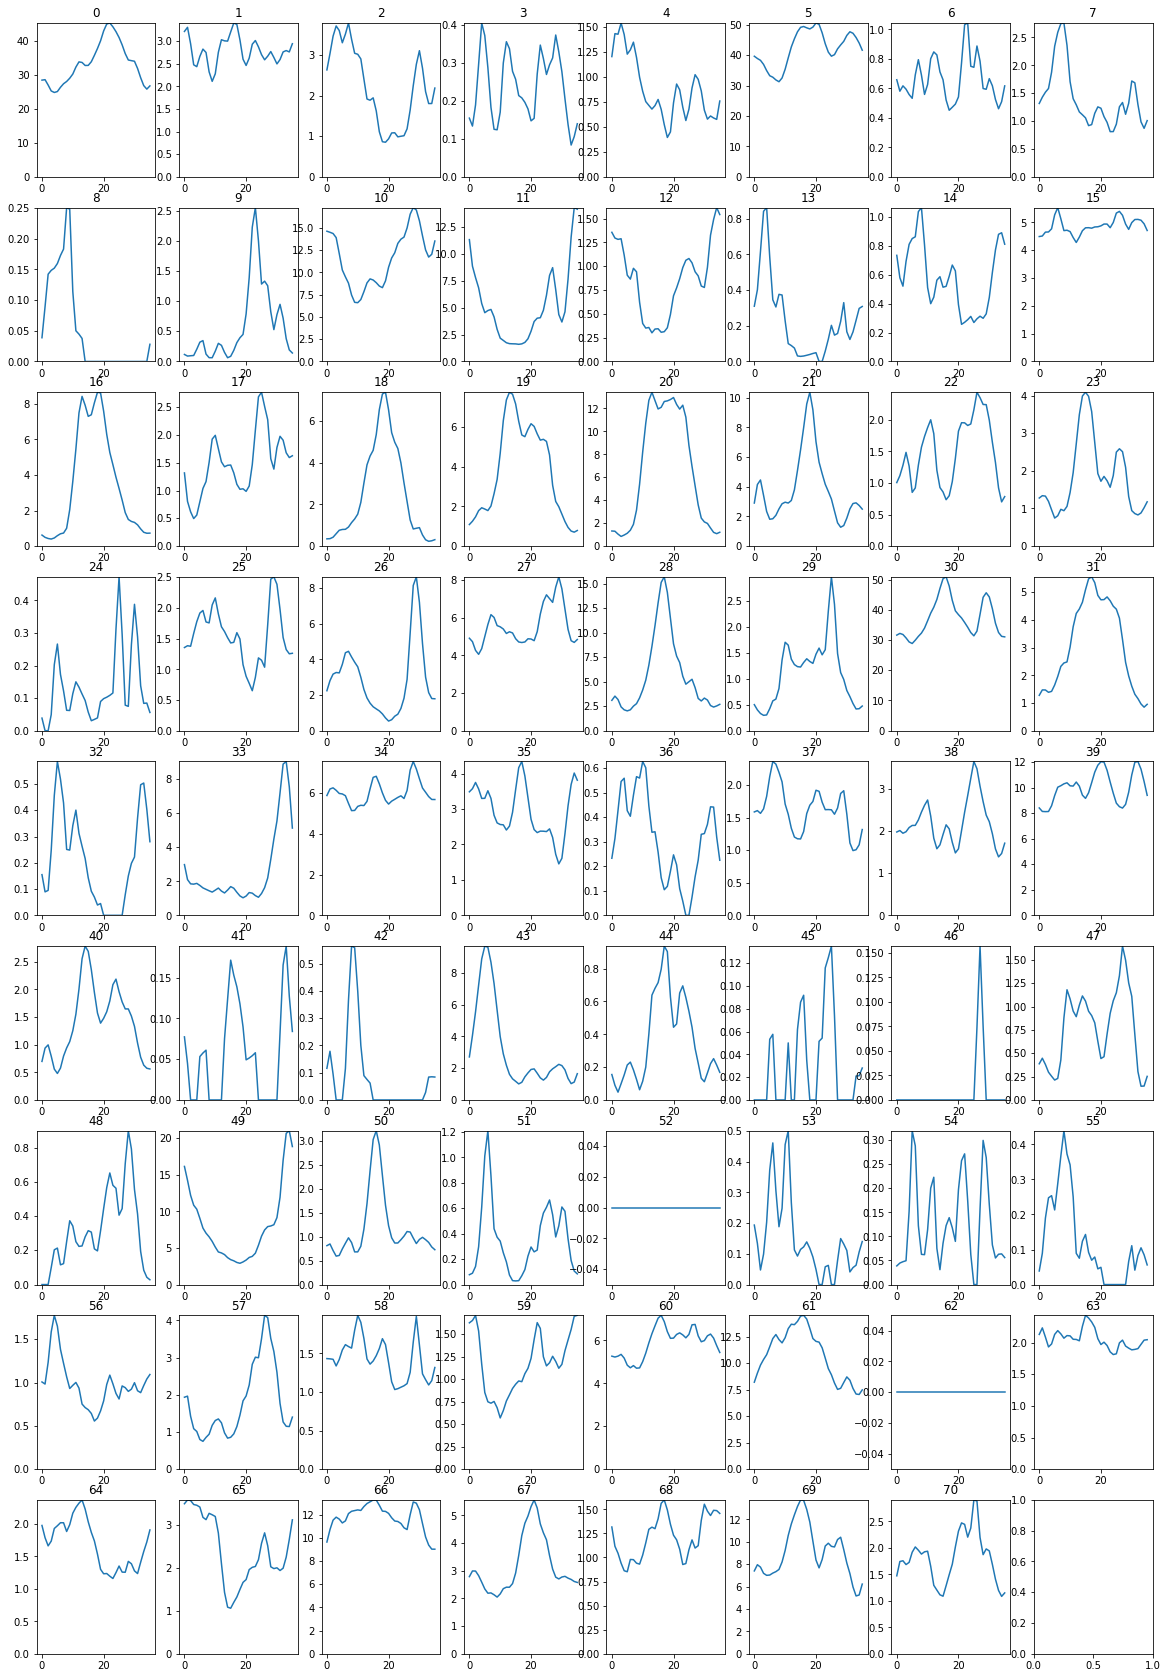

In [54]:
ncol=8
nrow=9
fig, ax = plt.subplots(nrow,ncol,figsize=(20,30))
for i in range(res.shape[0]):
    c = i%ncol
    r = int(i/ncol)
    ax[r,c].plot(res[i])
    ax[r,c].set_title(i)
    ax[r,c].set_ylim(0,np.nanmax(res[i]))

In [55]:
conditions = ["circ80","circ80_1","circ80_2","light","light","dark","dark"]
onlyArena = [False,False,False,False,True,False,True]
keys = ["circ80","circ80_1","circ80_2","light","light_arena","dark","dark_arena"]
print(list(zip(keys,conditions,onlyArena)))

[('circ80', 'circ80', False), ('circ80_1', 'circ80_1', False), ('circ80_2', 'circ80_2', False), ('light', 'light', False), ('light_arena', 'light', True), ('dark', 'dark', False), ('dark_arena', 'dark', True)]


In [56]:
myEhaHist = {}
for key,cond,onlyA in zip(keys,conditions,onlyArena):
    print(key,cond,onlyA)
    myEhaHist[key] = np.concatenate([getEhaHisto(ses,sSes,cond,onlyA) for ses,sSes in zip(myProject.sessionList,sSesList)])

circ80 circ80 False
circ80_1 circ80_1 False
circ80_2 circ80_2 False
light light False
light_arena light True
dark dark False
dark_arena dark True


In [57]:
print(myEhaHist.keys())
[myEhaHist[k].shape for k in myEhaHist]

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'light', 'light_arena', 'dark', 'dark_arena'])


[(1489, 36),
 (1489, 36),
 (1489, 36),
 (1489, 36),
 (1489, 36),
 (1489, 36),
 (1489, 36)]

(80, 36)


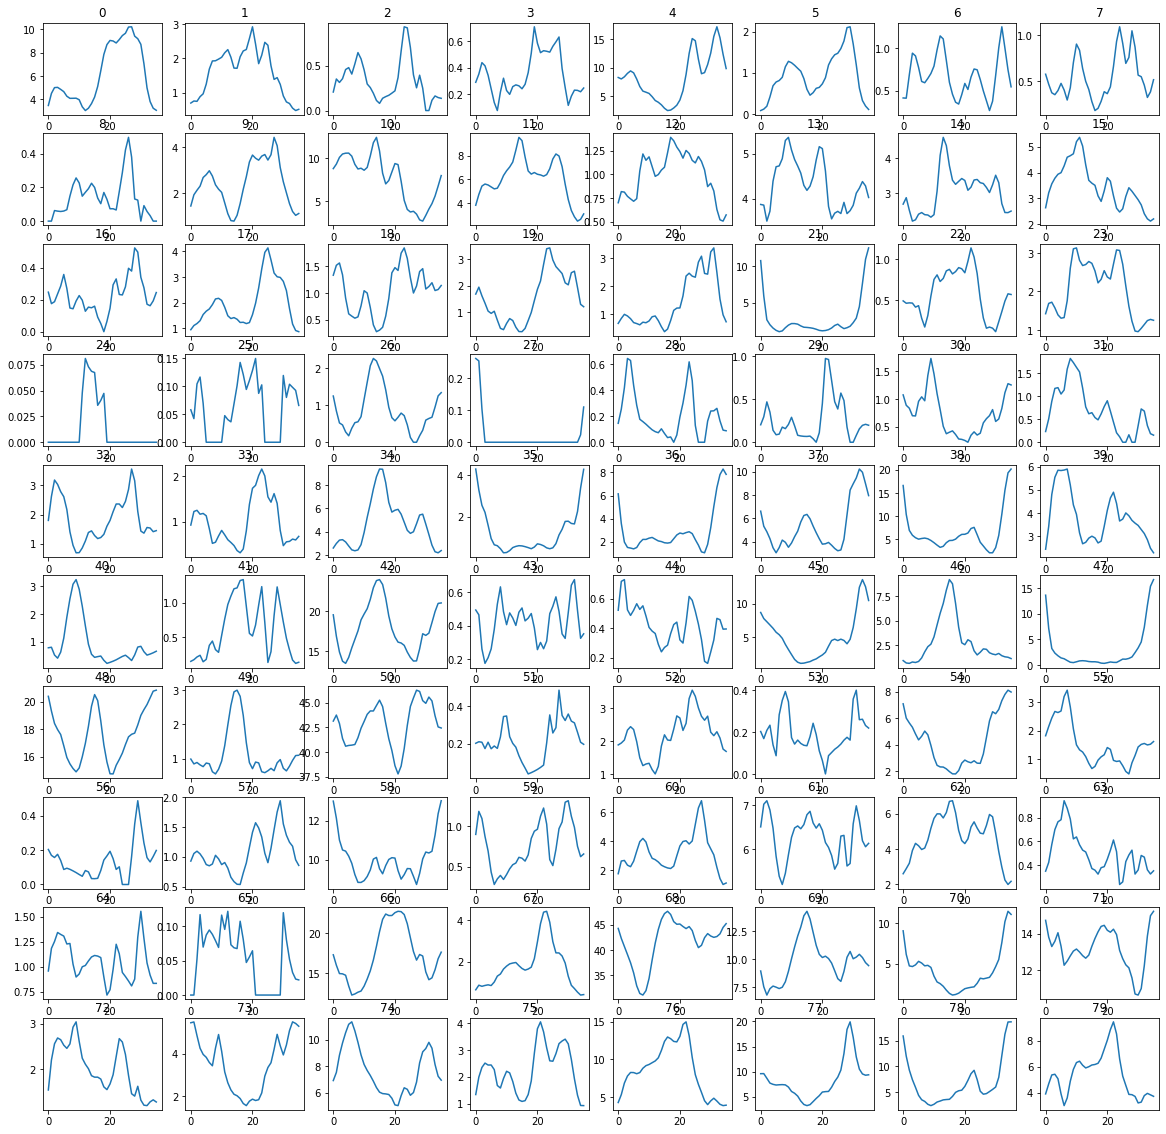

In [58]:
res= myEhaHist["dark_arena"][-80:,:]
print(res.shape)
ncol=8
nrow=10
fig, ax = plt.subplots(nrow,ncol,figsize=(20,20))

for i in range(res.shape[0]):
    c = i%ncol
    r = int(i/ncol)
    ax[r,c].plot(res[i])
    ax[r,c].set_title(i)

In [59]:
fn=myProject.dataPath+"/results/myEhaHist.pickle"
with open(fn, 'wb') as handle:
    pickle.dump(myHdHist, handle)

## Egocentric heading angle

In [60]:
def getEhaStats(ses,sSes,interName="circ80",onlyArena=False, conditionName="x"):
    """
    Get all the preferred direction and vector length
    """
    
    x_ref = 0
    y_ref = -45
    
    sSes.ap.load_pose_from_file() # get original hd data
    
    # calculate EHA
    eha = egocentric_direction_to_reference_point(sSes.ap.pose[:,1],
                                                  sSes.ap.pose[:,2],
                                                  sSes.ap.pose[:,4],
                                                  x_ref,y_ref)
    
    # replace HD by EHA in ap.pose_ori[:4]
    sSes.ap.pose_ori[:,4] = eha
    
    
    
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    if onlyArena:
        # this should come after setting the time intervals, will be reset when calling sSes.ap.set_intervals again
        sSes.ap.invalid_outside_spatial_area(shape="circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        # create the histogram
        n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10, smoothing=True)
        n.spatial_properties.head_direction_score() 
      
    # separate the variables
    cellId = [sSes.name+"_"+ n.name for n in sSes.cg.neuron_list]
    prefDir =[n.spatial_properties.hd_mean_direction_rad for n in sSes.cg.neuron_list]
    peakAngle = [n.spatial_properties.hd_peak_angle_rad for n in sSes.cg.neuron_list]
    peakRate = [n.spatial_properties.hd_peak_rate for n in sSes.cg.neuron_list]
    vectorLength =  [n.spatial_properties.hd_mean_vector_length for n in sSes.cg.neuron_list]
    
    df = pd.DataFrame({"cellId":cellId,
                       "condition":conditionName,
                      "prefDir":prefDir,
                       "peakAngle":peakAngle,
                       "peakRate":peakRate,
                      "vectorLength":vectorLength})
    
    sSes.ap.load_pose_from_file() # get original hd data
    
    return df

In [61]:
sSes = sSesList[41]
ses = myProject.sessionList[41]
df = getEhaStats(ses,sSes,interName="dark",onlyArena=True,conditionName="dark")
res = getEhaHisto(ses,sSes,interName="dark",onlyArena=True)

(71, 36)


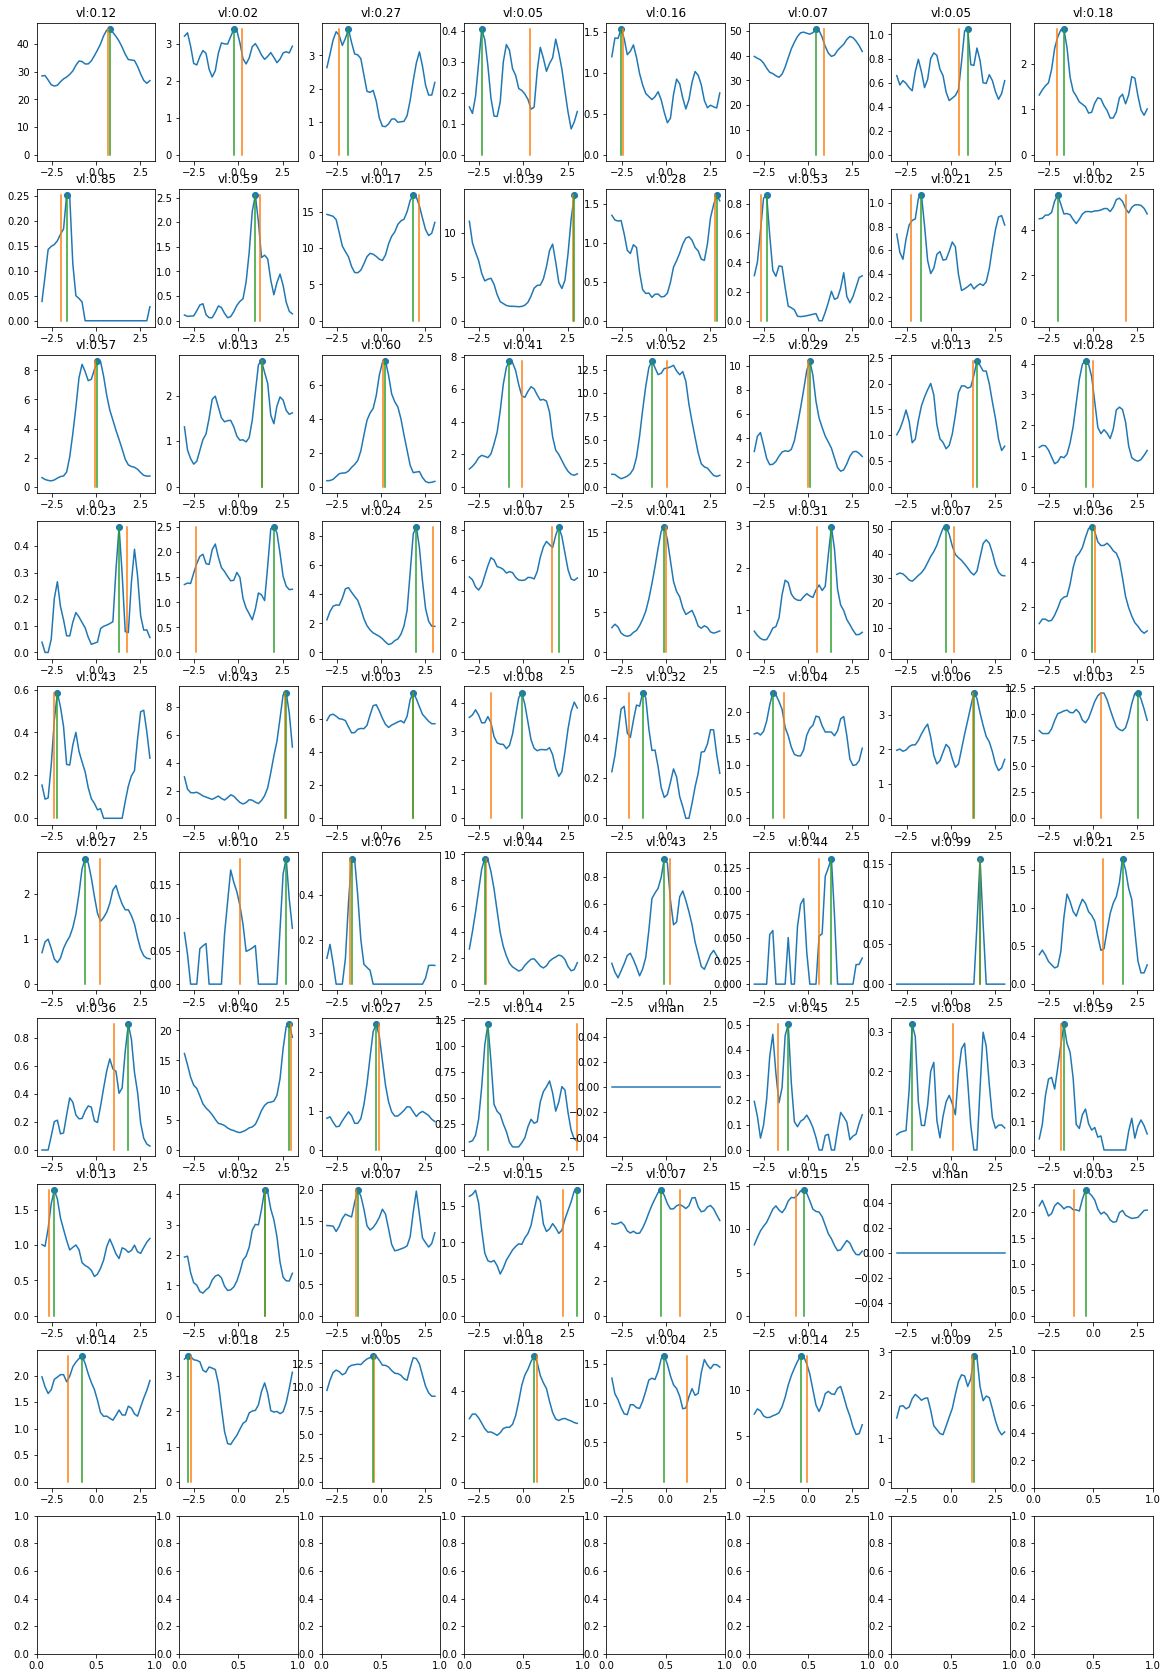

In [62]:
print(res.shape)
ncol=8
nrow=10
fig, ax = plt.subplots(nrow,ncol,figsize=(20,30))
angles = sSes.cg.neuron_list[0].spatial_properties.firing_rate_head_direction_mid_angles

for i in range(res.shape[0]):
    c = i%ncol
    r = int(i/ncol)
    ax[r,c].plot(angles, res[i])
    ax[r,c].plot([df.prefDir.iloc[i],df.prefDir.iloc[i]],[0,np.nanmax(res[i])])
    ax[r,c].plot([df.peakAngle.iloc[i],df.peakAngle.iloc[i]],[0,np.nanmax(res[i])])
    ax[r,c].scatter(df.peakAngle.iloc[i],df.peakRate.iloc[i])
    ax[r,c].set_title("vl:{:.2f}".format(df.vectorLength.iloc[i]))

In [63]:
conditions = ["circ80","circ80_1","circ80_2","light","light","dark","dark"]
onlyArena = [False,False,False,False,True,False,True]
keys = ["circ80","circ80_1","circ80_2","light","light_arena","dark","dark_arena"]
print(list(zip(keys,conditions,onlyArena)))

[('circ80', 'circ80', False), ('circ80_1', 'circ80_1', False), ('circ80_2', 'circ80_2', False), ('light', 'light', False), ('light_arena', 'light', True), ('dark', 'dark', False), ('dark_arena', 'dark', True)]


In [64]:
dfEhaStats=pd.DataFrame()
for key,cond,onlyA in zip(keys,conditions,onlyArena):
    print(key,cond,onlyA)
    condDf = pd.concat([getEhaStats(ses,sSes,cond,onlyA,key) for ses,sSes in zip(myProject.sessionList,sSesList)])
    dfEhaStats = pd.concat([dfEhaStats,condDf])

circ80 circ80 False
circ80_1 circ80_1 False
circ80_2 circ80_2 False
light light False
light_arena light True
dark dark False
dark_arena dark True


In [65]:
fn=fn=myProject.dataPath+"/results/myEhaStats.csv"
print(fn)
dfEhaStats.to_csv(fn,index=False)

/adata/projects/autopi_ca1/results/myEhaStats.csv


In [66]:
df_sel = dfEhaStats[dfEhaStats.condition=="dark_arena"].iloc[-80:,:]

(80, 36)


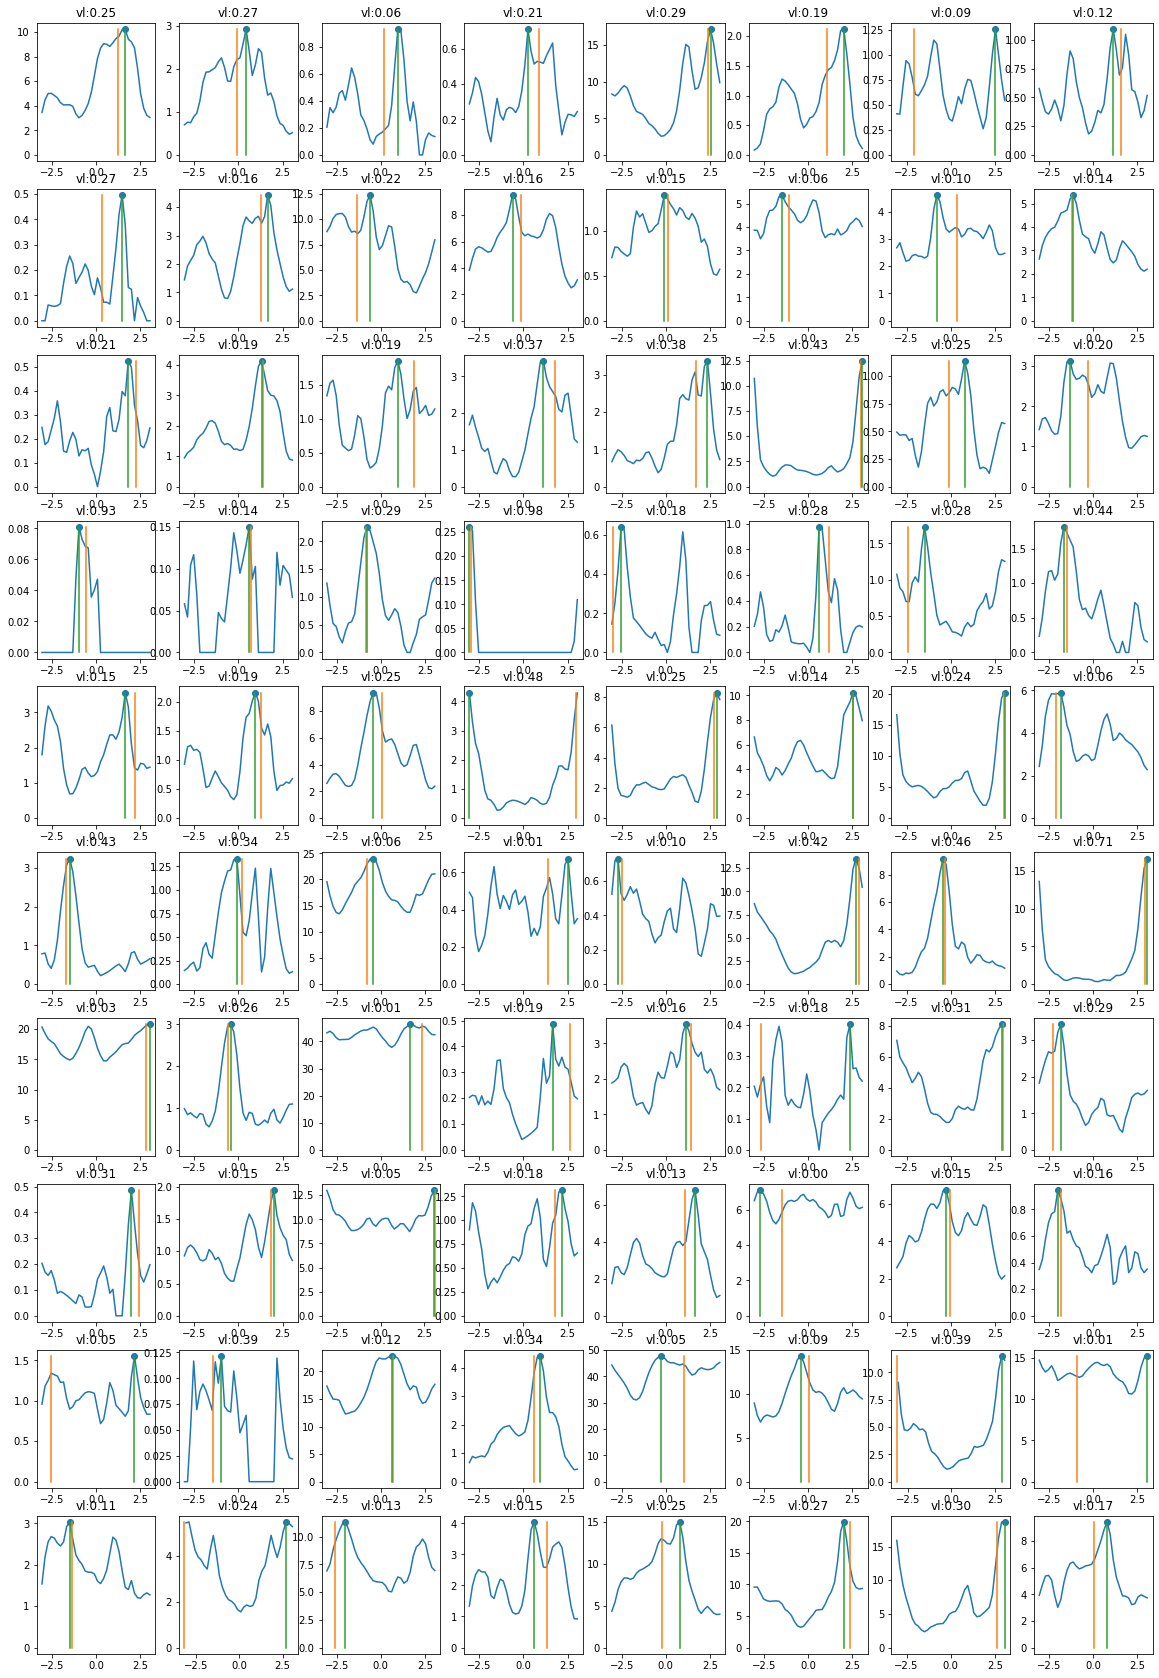

In [67]:
res= myEhaHist["dark_arena"][-80:,:]
print(res.shape)
ncol=8
nrow=10
fig, ax = plt.subplots(nrow,ncol,figsize=(20,30))

for i in range(res.shape[0]):
    c = i%ncol
    r = int(i/ncol)
    ax[r,c].plot(angles, res[i])
    ax[r,c].plot([df_sel.prefDir.iloc[i],df_sel.prefDir.iloc[i]],[0,np.nanmax(res[i])])
    ax[r,c].plot([df_sel.peakAngle.iloc[i],df_sel.peakAngle.iloc[i]],[0,np.nanmax(res[i])])
    ax[r,c].scatter(df_sel.peakAngle.iloc[i],df_sel.peakRate.iloc[i])
    ax[r,c].set_title("vl:{:.2f}".format(df_sel.vectorLength.iloc[i]))